# Saving Test Mask Predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sys.path.append('../src')
from utils import return_image, return_image_and_mask, return_mask
from UNet2D import UNet2D
from UNetMultiTask import UNetMultiTask
from datasets_only_segmentation import MycetomaDataset
from metrics import batch_dice_coeff, bce_dice_loss, dice_coefficient
from postprocessing import threshold_mask, post_process_binary_mask

In [2]:
DATA_DIR = '../data'

In [3]:
test_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test_dataset/*.jpg')])

print(f"Test length: {len(test_paths)}")

Test length: 167


In [4]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# no transforms
test_dataset = MycetomaDataset(test_paths, DATA_DIR, test_flag=True)

In [9]:
# Go batch size of one and no shuffling
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [16]:
# Create and load model save
model = UNetMultiTask(3, 1, 8)
state_dict = torch.load('../model_saves/train_bs_8_lr_2e-4_lw_0.2_best_model.pth', map_location=torch.device(device))

# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to(device)

model.eval();

In [19]:
# Put image through, save logit output and postprocessed mask
from tqdm import tqdm

save_dir1 = 'best_model_test_binary/'
save_dir1 = os.path.join(DATA_DIR, save_dir1)

save_dir2 = 'best_model_test_postproc_jpg/'
save_dir2 = os.path.join(DATA_DIR, save_dir2)

# Perform loop without computing gradients
with torch.no_grad():
    for idx, (inputs) in enumerate(tqdm(test_loader)):
        
        inputs = inputs.to(device)

        # Get logits mask prediction
        outputs, class_outs = model(inputs)

        pred = outputs[0][0].detach().cpu().numpy()

        binary_mask = threshold_mask(pred)
        postproc_mask = np.clip(post_process_binary_mask(binary_mask, threshold_fraction=0.05), 0, 1)

        # Save masks here
        # Modify the filename to include the suffix and change the extension
        image_path = test_paths[idx] # start with image path
        image_path = image_path.split('/', 1)[1] # remove first directory
        binary_mask_path = os.path.splitext(os.path.join(save_dir1, image_path))[0] + '_mask.tif'
        postproc_mask_path = os.path.splitext(os.path.join(save_dir2, image_path))[0] + '_mask.jpg'

        # Create the directory if it does not exist
        #os.makedirs(os.path.dirname(logit_mask_path), exist_ok=True)
        os.makedirs(os.path.dirname(binary_mask_path), exist_ok=True)
        os.makedirs(os.path.dirname(postproc_mask_path), exist_ok=True)

        # Save the masks as a TIFF image
        binary_mask_image = Image.fromarray(binary_mask)
        binary_mask_image.save(binary_mask_path, format='TIFF')

        # Save the post_processed masks as a JPG image
        # Scale the mask to 0-255
        postproc_mask = postproc_mask * 255

        # Convert the numpy array to a PIL Image and save as JPG
        postproc_mask_image = Image.fromarray(postproc_mask)
        postproc_mask_image.save(postproc_mask_path, format='JPEG')


  0%|          | 0/167 [00:00<?, ?it/s]

100%|██████████| 167/167 [02:18<00:00,  1.20it/s]


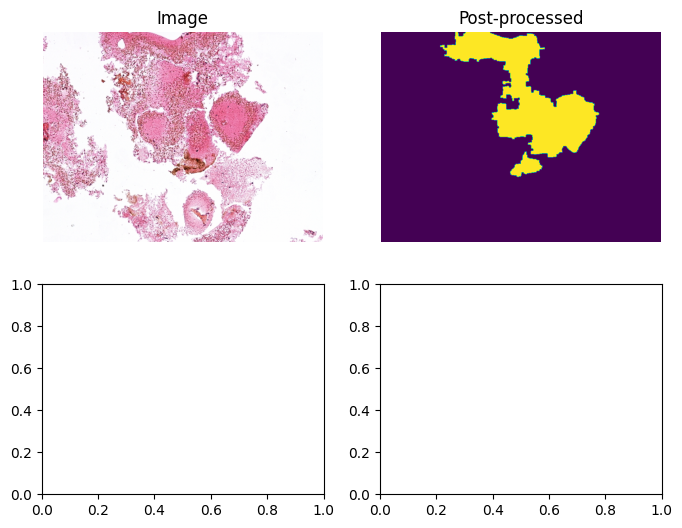

In [15]:
# Check a few

test_path = test_paths[67]

image = return_image(DATA_DIR, test_path)

rel_path = test_path.split('/', 1)[1] # remove first directory
#logit_mask_path = os.path.join('multitask_validation', rel_path)
postproc_mask_path = os.path.join('multitask_postproc_test', rel_path)

#logit_pred = return_mask(DATA_DIR, logit_mask_path)
postproc_pred = return_mask(DATA_DIR, postproc_mask_path)

# Plot prediction before and after processing
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0][0].imshow(image)
ax[0][0].set_title('Image')
ax[0][0].axis('off')

#ax[0][1].imshow(gt)
#ax[0][1].set_title('GT')
#ax[0][1].axis('off')

#ax[1][0].imshow(logit_pred)
#ax[1][0].set_title('Logit Output')
#ax[1][0].axis('off')

ax[0][1].imshow(postproc_pred)
ax[0][1].set_title('Post-processed')
ax[0][1].axis('off')

plt.show()